In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os.path

from os import getcwd
import numpy as np
import pandas as pd
import hdf5storage
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat, loadmat
import math
from scipy.fftpack import fft, ifft
from scipy.stats import zscore, f_oneway
#import samplerate
import multiprocessing as mp
from scipy.signal import resample
import random
import pyreadr
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
from sklearn import decomposition
import statsmodels.api as sm
import scipy
import matplotlib.patches as mpatches
import statsmodels.stats.multitest as multitest

import mne
from mne.preprocessing import ICA
from mne.time_frequency import tfr_morlet

import textgrids

import plotly
import plotly.graph_objs as go
import random

In [2]:
stn_file = hdf5storage.loadmat("atlas_index.mat")
stn_vertices = stn_file['atlases'][0]['roi'][0][1][0]['fv'][0]['vertices']
stn_faces = stn_file['atlases'][0]['roi'][0][1][0]['fv'][0]['faces']
stn_faces = stn_faces.astype(int) - 1

stn_vertices_motor = stn_file['atlases'][0]['roi'][1][1][0]['fv'][0]['vertices']
stn_faces_motor = stn_file['atlases'][0]['roi'][1][1][0]['fv'][0]['faces']
stn_faces_motor = stn_faces_motor.astype(int) - 1

stn_vertices_associative = stn_file['atlases'][0]['roi'][2][1][0]['fv'][0]['vertices']
stn_faces_associative = stn_file['atlases'][0]['roi'][2][1][0]['fv'][0]['faces']
stn_faces_associative = stn_faces_associative.astype(int) - 1

stn_vertices_limbic = stn_file['atlases'][0]['roi'][3][1][0]['fv'][0]['vertices']
stn_faces_limbic = stn_file['atlases'][0]['roi'][3][1][0]['fv'][0]['faces']
stn_faces_limbic = stn_faces_limbic.astype(int) - 1

In [3]:
def tri_area(verts, tri):
    #calculate the area of each mesh triangle 
    verts = np.asarray(verts)
    faces = np.asarray(tri)
    area = np.zeros(len(tri))
    p_triangles =  verts[tri]  # coordinates of triangle vertices

    for k, T in enumerate(p_triangles):
        a = np.linalg.norm(T[0] - T[1])
        b = np.linalg.norm(T[1] - T[2])
        c = np.linalg.norm(T[2] - T[0])
        p = (a+b+c) / 2
        area[k] = np.sqrt(p*(p-a)*(p-b)*(p-c))
    return area

In [4]:
i_stn, j_stn, k_stn = stn_faces.T
x_stn, y_stn, z_stn = stn_vertices.T

i_stn_motor, j_stn_motor, k_stn_motor = stn_faces_motor.T
x_stn_motor, y_stn_motor, z_stn_motor = stn_vertices_motor.T

i_stn_associative, j_stn_associative, k_stn_associative = stn_faces_associative.T
x_stn_associative, y_stn_associative, z_stn_associative = stn_vertices_associative.T

i_stn_limbic, j_stn_limbic, k_stn_limbic = stn_faces_limbic.T
x_stn_limbic, y_stn_limbic, z_stn_limbic = stn_vertices_limbic.T

In [15]:
pca = decomposition.PCA(n_components=3)

pca.fit(np.array([x_stn, y_stn, z_stn]).T)
stn_pca_xyz = pca.transform(np.array([x_stn, y_stn, z_stn]).T)
stn_pca_ijk = pca.transform(np.array([i_stn, j_stn, k_stn]).T)

PCA(n_components=3)

In [6]:
mer_loc = pd.read_csv('mer_loc.csv', index_col=0)

cue_unit = pd.read_csv('cue_unit.csv', index_col=0)
cue_unit.shape

(229, 15)

In [7]:
sig_diff_c = np.array([28, 48, 122, 176, 184, 185, 189, 199])

sig_diff_v = np.array([30, 129, 168, 199, 74, 176])

cue_unit_c = mer_loc.iloc[sig_diff_c]
cue_unit_v = mer_loc.iloc[sig_diff_v]

cue_unit_c_pca = pca.transform(cue_unit_c.iloc[:, 10:13])
cue_unit_v_pca = pca.transform(cue_unit_v.iloc[:, 10:13])

In [8]:
unit_cue_pos = cue_unit[cue_unit['Cue dir'] == "+"].index
unit_cue_neg = cue_unit[cue_unit['Cue dir'] == "-"].index

unit_cue_pos = mer_loc.iloc[unit_cue_pos]
unit_cue_neg = mer_loc.iloc[unit_cue_neg]

unit_cue_pos_pca = pca.transform(unit_cue_pos.iloc[:, 10:13])
unit_cue_neg_pca = pca.transform(unit_cue_neg.iloc[:, 10:13])


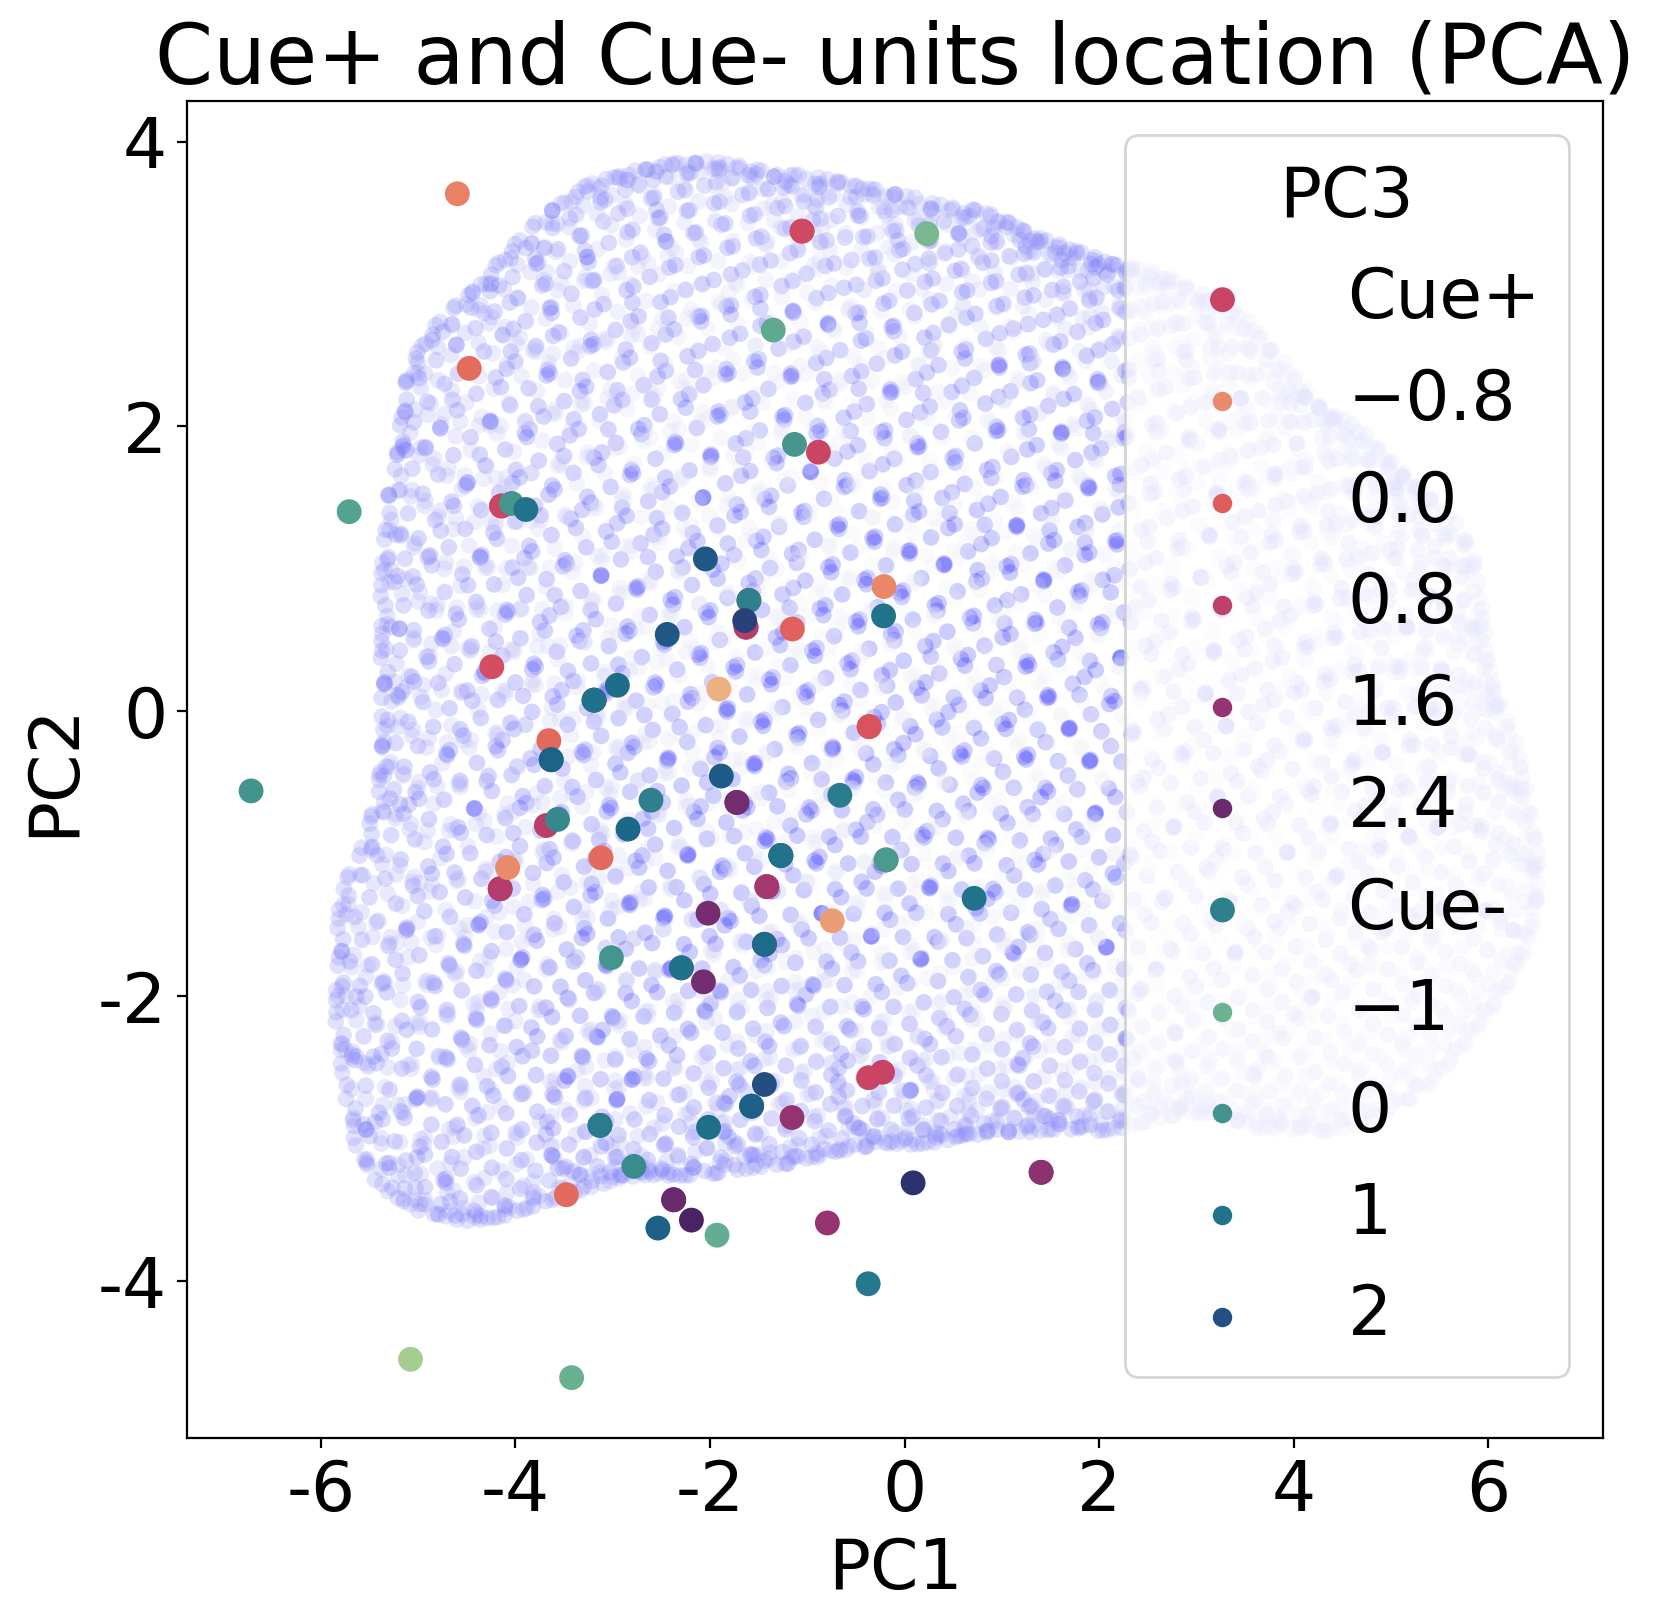

In [33]:
# PC1-PC2
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 8), dpi=200)
axs.patch.set_alpha(0)

sns.scatterplot(stn_pca_xyz[:, 0], stn_pca_xyz[:, 1], 
                ax=axs, hue=stn_pca_xyz[:, 2], legend=0, palette='light:b', linewidth=0, alpha=0.2)

sns.scatterplot(unit_cue_pos_pca[:, 0], unit_cue_pos_pca[:, 1], 
                hue=unit_cue_pos_pca[:, 2], palette='flare', ax=axs, 
                label='Cue+', linewidth=0, s=80, legend='brief')
sns.scatterplot(unit_cue_neg_pca[:, 0], unit_cue_neg_pca[:, 1], 
                hue=unit_cue_neg_pca[:, 2], palette='crest', ax=axs, 
                label='Cue-', linewidth=0, s=80, legend='brief')

axs.legend(title='PC3', fontsize=25, title_fontsize=25, loc=1)
axs.set_xlabel('PC1', fontsize=25)
axs.set_ylabel('PC2', fontsize=25)
axs.set_title('Cue+ and Cue- units location (PCA)', fontsize=30)
axs.set_xticklabels(axs.get_xticks().astype(int), fontsize=25)
axs.set_yticklabels(axs.get_yticks().astype(int), fontsize=25)
plt.show();

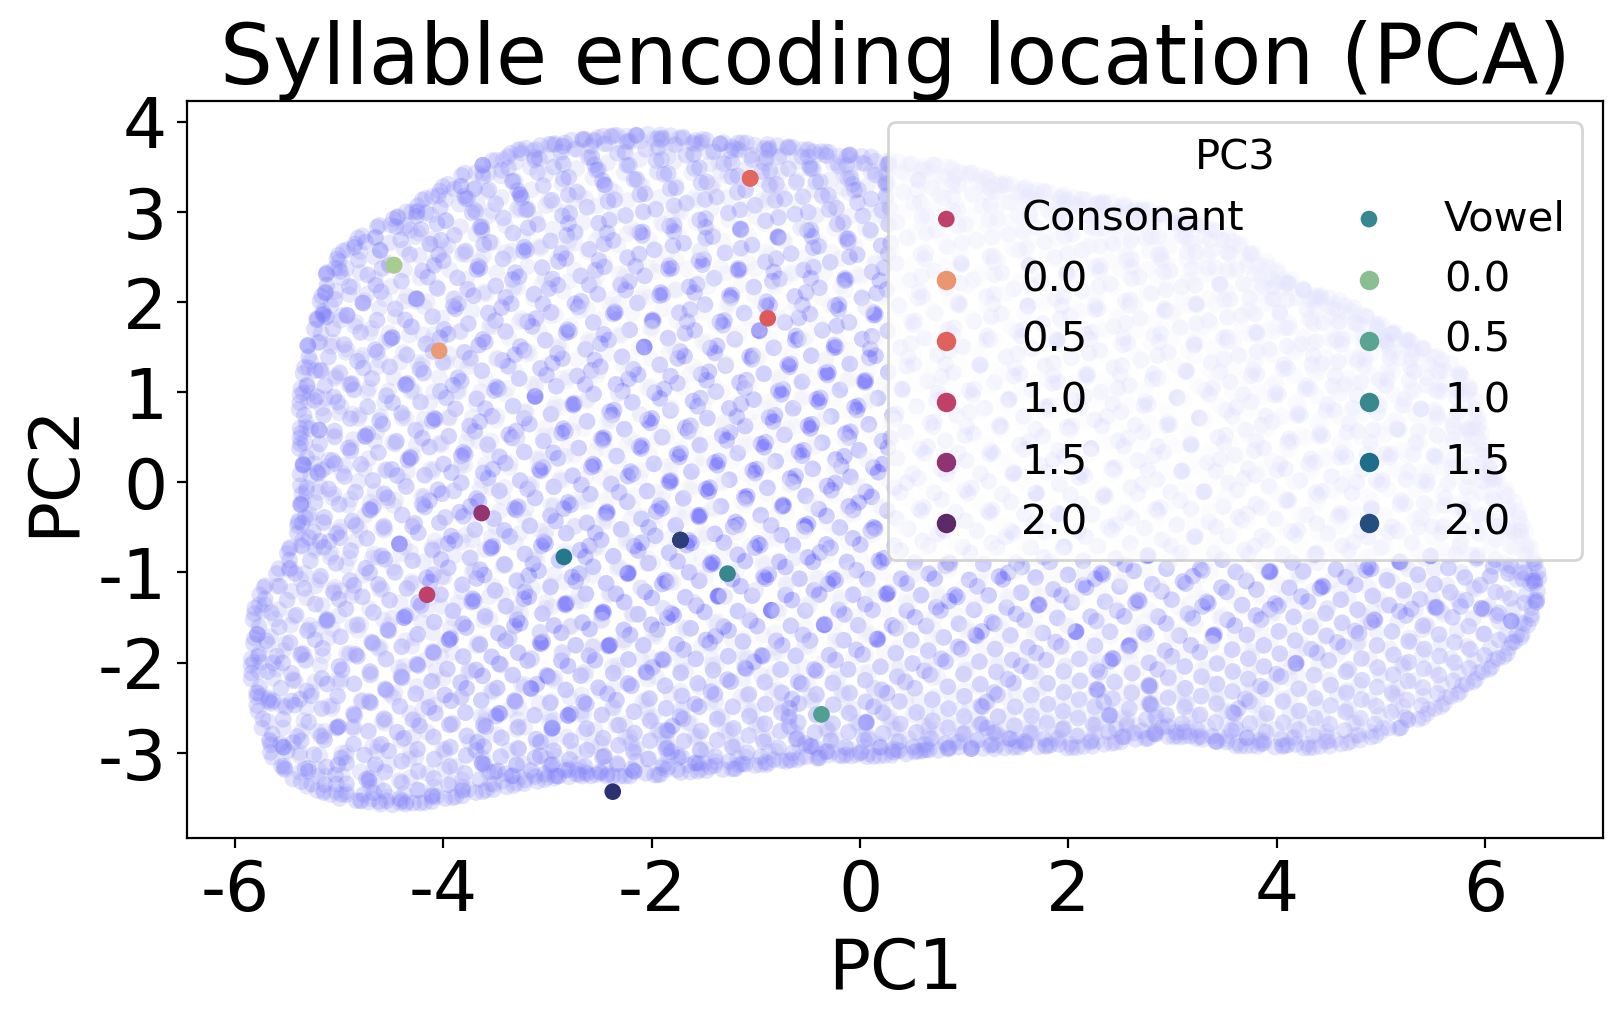

In [51]:
# PC1-PC2
fig, axs = plt.subplots(1, 1, figsize=(8, 5), dpi=200, constrained_layout=1)
axs.patch.set_alpha(0)

sns.scatterplot(stn_pca_xyz[:, 0], stn_pca_xyz[:, 1], 
                ax=axs, hue=stn_pca_xyz[:, 2], legend=0, palette='light:b', linewidth=0, alpha=0.2)
sns.scatterplot(cue_unit_c_pca[:, 0], cue_unit_c_pca[:, 1], 
                hue=cue_unit_c_pca[:, 2], palette='flare', legend='brief', ax=axs, 
                label='Consonant', linewidth=0)
sns.scatterplot(cue_unit_v_pca[:, 0], cue_unit_v_pca[:, 1], 
                hue=cue_unit_v_pca[:, 2], palette='crest', legend='brief', ax=axs, 
                label='Vowel', markers='square', linewidth=0)
axs.legend(title='PC3', fontsize=15, title_fontsize=15, ncol=2)
axs.set_xlabel('PC1', fontsize=25)
axs.set_ylabel('PC2', fontsize=25)
axs.set_title('Syllable encoding location (PCA)', fontsize=30)
axs.set_xticklabels(axs.get_xticks().astype(int), fontsize=25)
axs.set_yticklabels(axs.get_yticks().astype(int), fontsize=25)
plt.show();

In [9]:
unit_cue = cue_unit[cue_unit['Cue'] == "After"].index
unit_speech = cue_unit[[[cue_unit['Speech'] == 'Before'] or [cue_unit['Speech'] == 'After']][0][0]].index
all_units = cue_unit.index

unit_cue = mer_loc.iloc[unit_cue]
unit_speech = mer_loc.iloc[unit_speech]
all_units = mer_loc.iloc[all_units]

unit_cue_pca = pca.transform(unit_cue.iloc[:, 10:13])
unit_speech_pca = pca.transform(unit_speech.iloc[:, 10:13])
all_units_pca = pca.transform(all_units.iloc[:, 10:13])

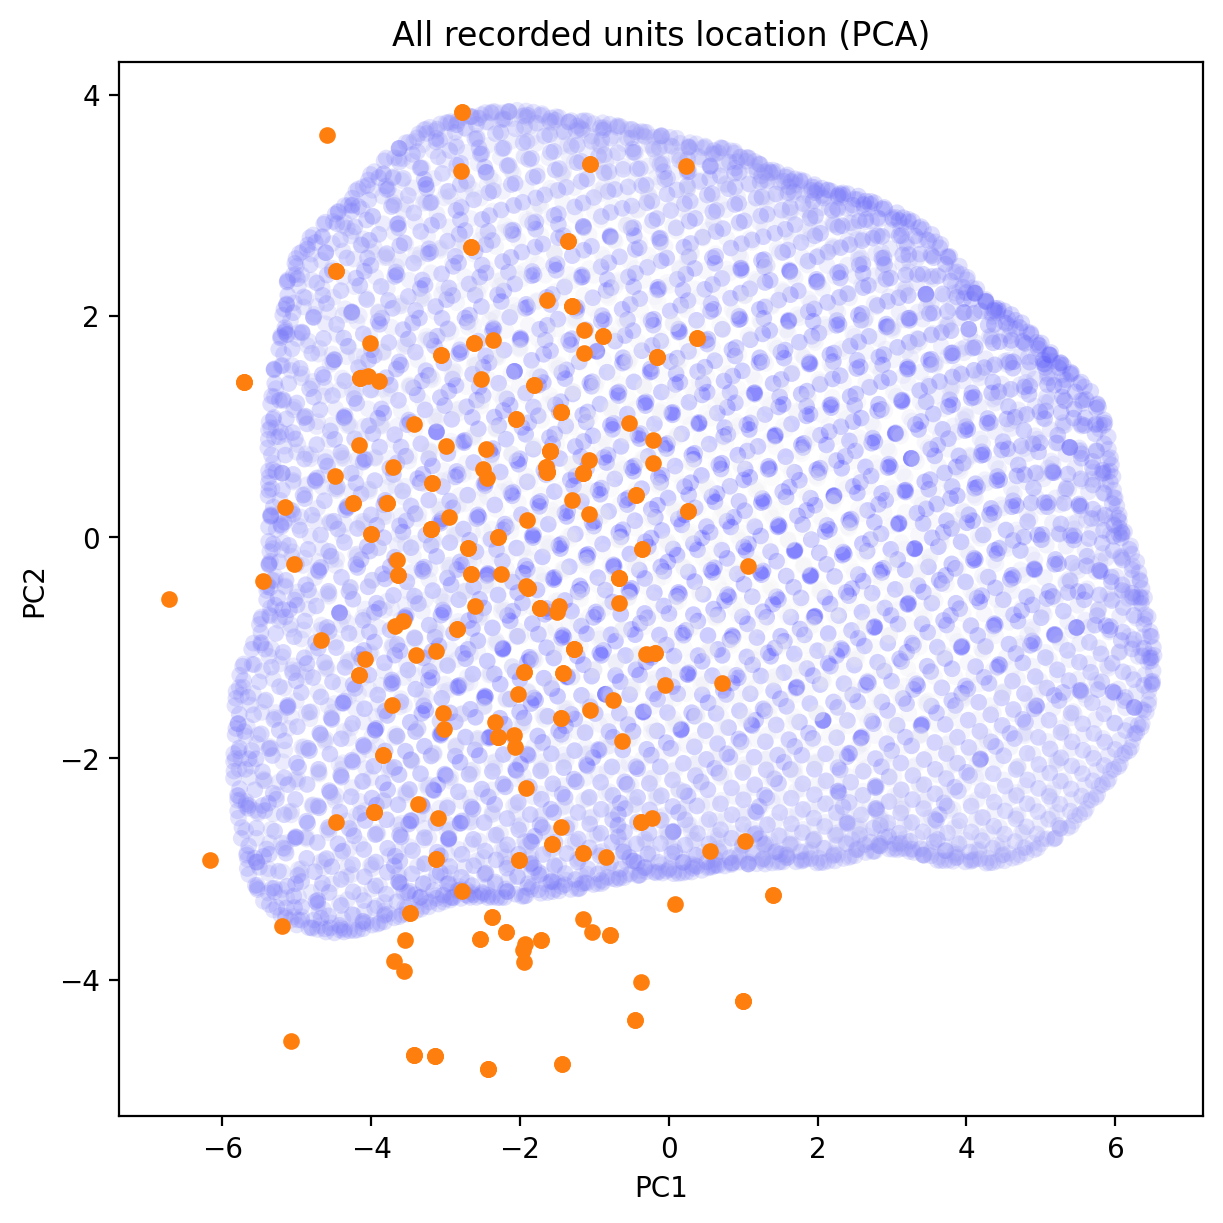

In [18]:
# PC1-PC2
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 6), dpi=200)

sns.scatterplot(stn_pca_xyz[:, 0], stn_pca_xyz[:, 1], 
                ax=axs, hue=stn_pca_xyz[:, 2], legend=0, palette='light:b', linewidth=0, alpha=0.2)
sns.scatterplot(all_units_pca[:, 0], all_units_pca[:, 1], 
                palette='flare', legend='brief', ax=axs, 
                linewidth=0)
'''
sns.scatterplot(cue_unit_c_pca[:, 0], cue_unit_c_pca[:, 1], 
                hue=cue_unit_c_pca[:, 2], palette='crest', legend='brief', ax=axs, 
                label='Consonant', linewidth=0)
sns.scatterplot(cue_unit_v_pca[:, 0], cue_unit_v_pca[:, 1], 
                hue=cue_unit_v_pca[:, 2], palette='crest', legend='brief', ax=axs, 
                label='Vowel', markers='square', linewidth=0)
'''

axs.set_xlabel('PC1')
axs.set_ylabel('PC2')
axs.set_title('All recorded units location (PCA)')
plt.show();

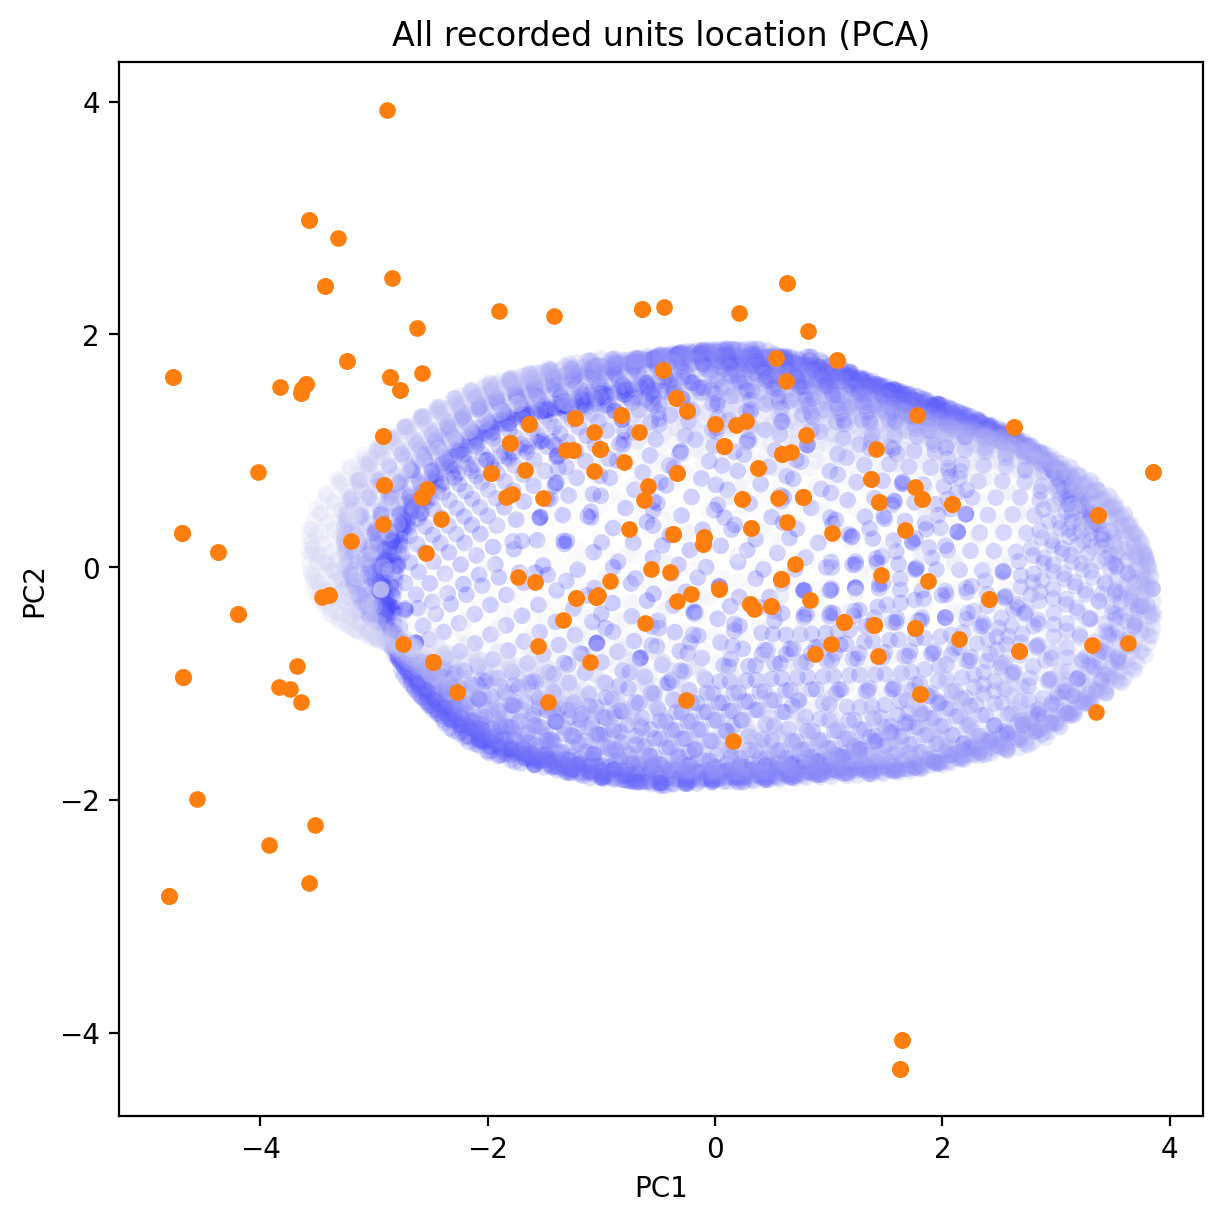

In [19]:
# PC2-PC3
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 6), dpi=200)

sns.scatterplot(stn_pca_xyz[:, 1], stn_pca_xyz[:, 2], 
                ax=axs, hue=stn_pca_xyz[:, 0], legend=0, palette='light:b', linewidth=0, alpha=0.2)
sns.scatterplot(all_units_pca[:, 1], all_units_pca[:, 2], 
                palette='flare', legend='brief', ax=axs, 
                linewidth=0)
'''
sns.scatterplot(cue_unit_c_pca[:, 0], cue_unit_c_pca[:, 1], 
                hue=cue_unit_c_pca[:, 2], palette='crest', legend='brief', ax=axs, 
                label='Consonant', linewidth=0)
sns.scatterplot(cue_unit_v_pca[:, 0], cue_unit_v_pca[:, 1], 
                hue=cue_unit_v_pca[:, 2], palette='crest', legend='brief', ax=axs, 
                label='Vowel', markers='square', linewidth=0)
'''

axs.set_xlabel('PC1')
axs.set_ylabel('PC2')
axs.set_title('All recorded units location (PCA)')
plt.show();

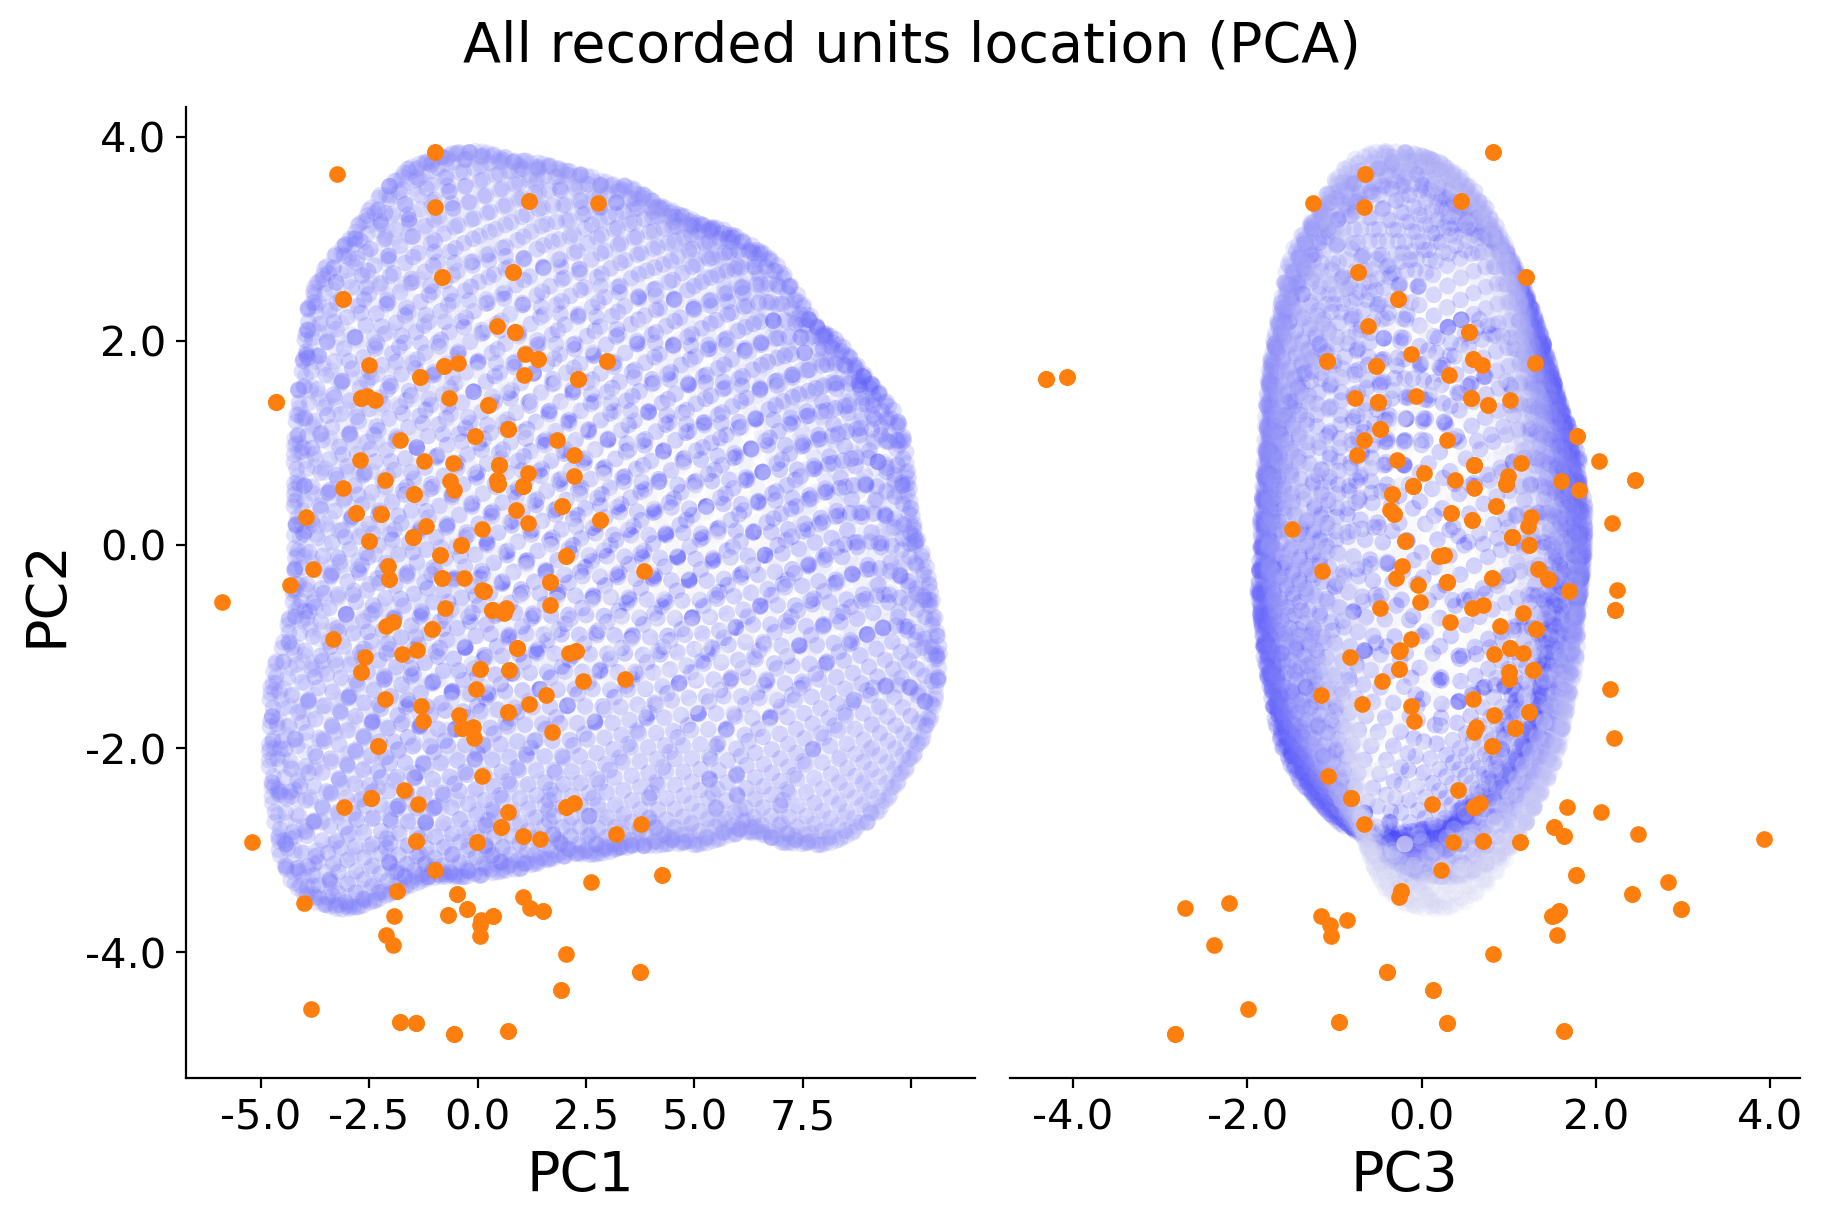

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(9, 6), dpi=200, constrained_layout=True)
axs[0].patch.set_alpha(0)
axs[1].patch.set_alpha(0)

# PC1-PC2
sns.scatterplot(stn_pca_xyz[:, 0], stn_pca_xyz[:, 1], 
                ax=axs[0], hue=stn_pca_xyz[:, 2], legend=0, palette='light:b', linewidth=0, alpha=0.2)
sns.scatterplot(all_units_pca[:, 0], all_units_pca[:, 1], 
                palette='flare', legend='brief', ax=axs[0], 
                linewidth=0)

axs[0].set_xlabel('PC1', fontsize=20)
axs[0].set_ylabel('PC2', fontsize=20)
axs[0].set_xticklabels(axs[0].get_xticks(), fontsize=15)
axs[0].set_yticklabels(axs[0].get_yticks(), fontsize=15)
sns.despine(ax=axs[0], top=True, right=True, left=False, bottom=False)

# PC2-PC3
sns.scatterplot(stn_pca_xyz[:, 2], stn_pca_xyz[:, 1], 
                ax=axs[1], hue=stn_pca_xyz[:, 0], legend=0, palette='light:b', linewidth=0, alpha=0.2)
sns.scatterplot(all_units_pca[:, 2], all_units_pca[:, 1], 
                palette='flare', legend='brief', ax=axs[1], 
                linewidth=0)

axs[1].set_xlabel('PC3', fontsize=20)
axs[1].set_yticks([])
axs[1].set_xticklabels(axs[1].get_xticks(), fontsize=15)
sns.despine(ax=axs[1], top=True, right=True, left=True, bottom=False)

plt.suptitle('All recorded units location (PCA)', fontsize=20)
plt.show();

In [32]:
axs[1].get_xticks()

-6.0

In [170]:
pd.concat([cue_unit_v, cue_unit_c]).index


Int64Index([30, 129, 168, 199, 74, 176, 28, 48, 122, 176, 184, 185, 189, 199], dtype='int64')

In [175]:
cue_unit_v.index | cue_unit_c.index

Int64Index([28, 30, 48, 74, 122, 129, 168, 176, 184, 185, 189, 199], dtype='int64')

In [172]:
pd.concat([cue_unit_v, cue_unit_c]).index & [26, 30, 48, 56, 117, 129, 153, 162, 171, 188, 199, 215, 216]

Int64Index([30, 129, 199, 48, 199], dtype='int64')

In [52]:
beta_units = [26, 30, 48, 56, 117, 129, 153, 162, 171, 188, 199, 215, 216]
beta_units = mer_loc.iloc[beta_units]

beta_units_pca = pca.transform(beta_units.iloc[:, 10:13])

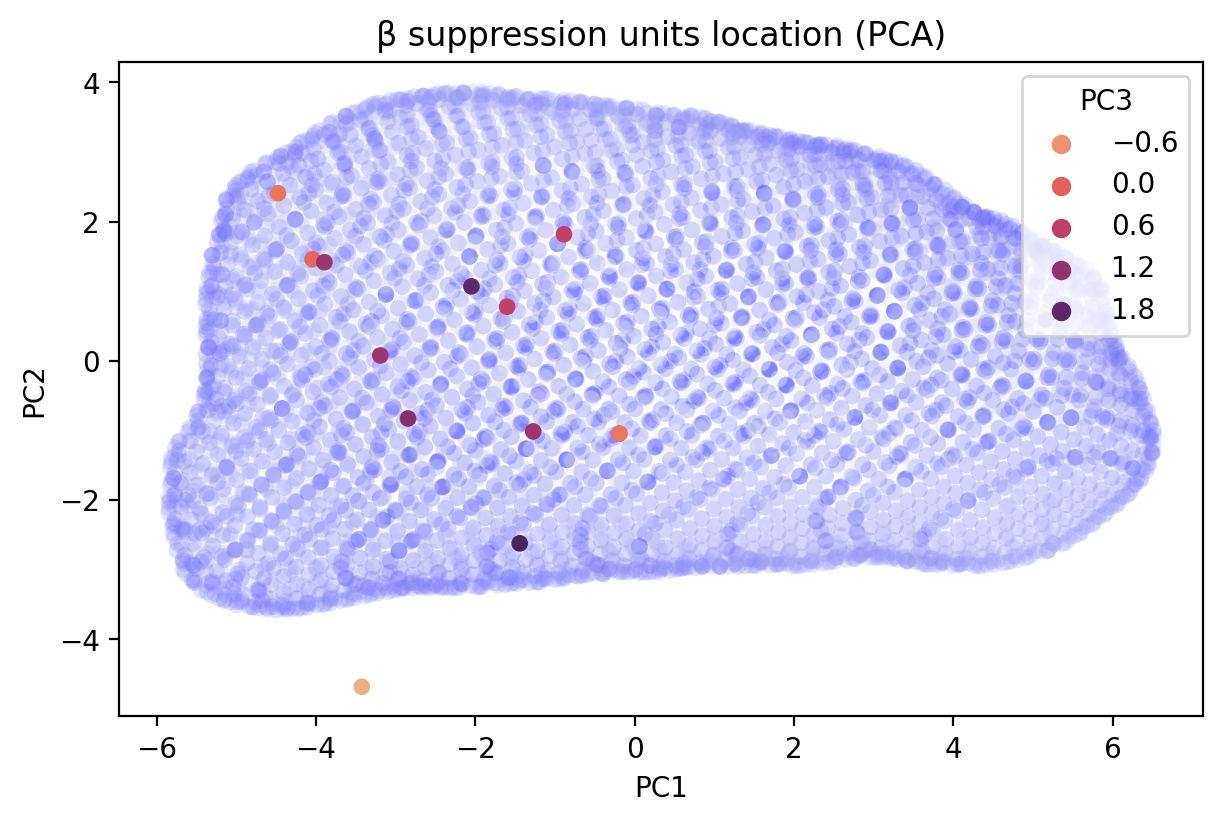

In [158]:
# PC1-PC2
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 4), dpi=200)

sns.scatterplot(stn_pca_xyz[:, 0], stn_pca_xyz[:, 1], 
                ax=axs, hue=stn_pca_xyz[:, 2], legend=0, palette='light:b', linewidth=0, alpha=0.2)

sns.scatterplot(beta_units_pca[:, 0], beta_units_pca[:, 1], 
                hue=beta_units_pca[:, 2], palette='flare', legend='brief', ax=axs, 
                linewidth=0)

axs.legend(title='PC3')
axs.set_xlabel('PC1')
axs.set_ylabel('PC2')
axs.set_title('β suppression units location (PCA)')
plt.show();

In [164]:
deff_x_beta = (beta_units['MNI_X'] - beta_units['MNI_X'].mean()) ** 2
deff_y_beta = (beta_units['MNI_Y'] - beta_units['MNI_Y'].mean()) ** 2
deff_z_beta = (beta_units['MNI_Z'] - beta_units['MNI_Z'].mean()) ** 2

sd_trial_beta = 0
for item in range(len(beta_units)):
    sd_trial_beta += np.sqrt(deff_x_beta.iloc[item] + deff_y_beta.iloc[item] + deff_z_beta.iloc[item])
sd_trial_beta = sd_trial_beta / len(deff_x_beta)


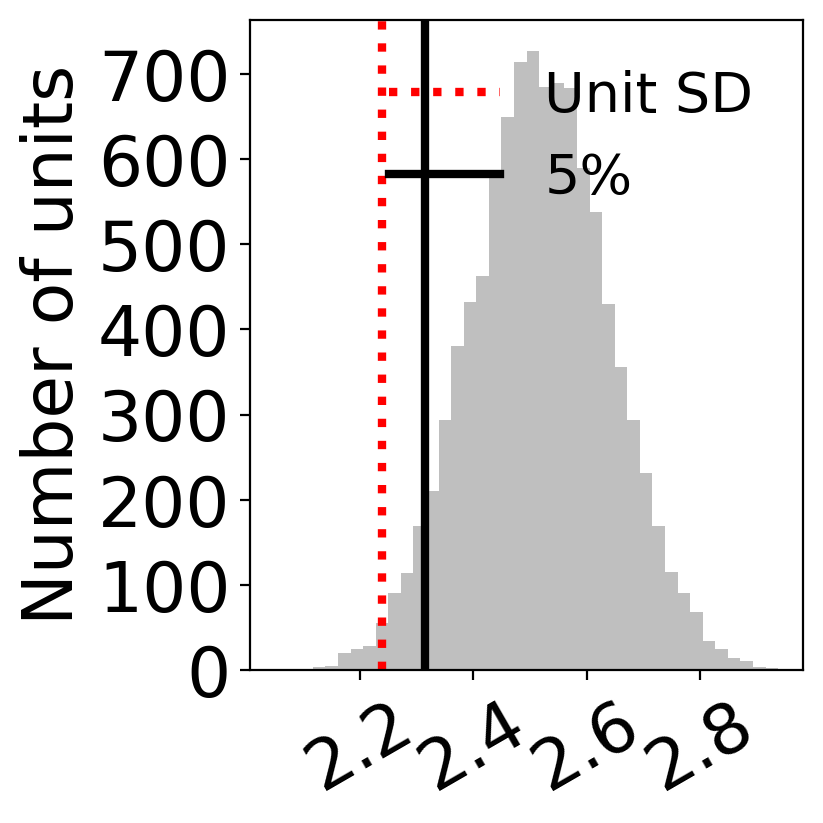

In [165]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4), dpi=200, constrained_layout=1)
axs.patch.set_alpha(0)

axs.hist(rand_all_sd, color='grey', alpha=0.5, bins=40)
axs.axvline(sd_trial_beta, color='r', linewidth=3, label='Unit SD', linestyle='dotted')
axs.axvline(np.sort(rand_all_sd)[int(rand_all_sd.shape[0]*0.05)], color='k', linewidth=3, label='5%')
axs.legend(frameon=0, fontsize=20, loc=1)
axs.set_xticklabels(axs.get_xticks(), fontsize=25, rotation=30)
axs.set_yticklabels(axs.get_yticks().astype(int), fontsize=25)
axs.set_ylabel('Number of units', fontsize=25)

plt.show();


In [66]:
rand_x_mean = []
rand_y_mean = []
rand_z_mean = []
rand_x_sd = []
rand_y_sd = []
rand_z_sd = []
rand_all_sd = []

for i in range(10000):
    rand_unit = mer_loc.iloc[random.sample(range(mer_loc.shape[0]), 50)]
    rand_x = rand_unit['MNI_X']
    rand_y = rand_unit['MNI_Y']
    rand_z = rand_unit['MNI_Z']

    rand_x_mean.append(rand_x.mean())
    rand_y_mean.append(rand_y.mean())
    rand_z_mean.append(rand_z.mean())

    rand_x_sd.append(np.std(rand_x))
    rand_y_sd.append(np.std(rand_y))
    rand_z_sd.append(np.std(rand_z))
    
    diff_x = (rand_x - rand_x.mean()) ** 2
    diff_y = (rand_y - rand_y.mean()) ** 2
    diff_z = (rand_z - rand_z.mean()) ** 2
    
    sd_trial = 0
    for item in range(len(diff_x)):
        sd_trial += np.sqrt(diff_x.iloc[item] + diff_y.iloc[item] + diff_z.iloc[item])
    sd_trial = sd_trial / len(diff_x)
    rand_all_sd.append(sd_trial)
    
    #for i2 in range(50):
        


rand_x_mean = np.array(rand_x_mean)
rand_y_mean = np.array(rand_y_mean)
rand_z_mean = np.array(rand_z_mean)
rand_x_sd = np.array(rand_x_sd)
rand_y_sd = np.array(rand_y_sd)
rand_z_sd = np.array(rand_z_sd)
rand_all_sd = np.array(rand_all_sd)


In [56]:
cue_pos = []
cue_neg = []
cue_mixed = []
speech_pos = []
speech_neg = []
speech_mixed = []

for item in range(cue_unit.shape[0]):
    if cue_unit.iloc[item, 2] == "After":
        if cue_unit.iloc[item, 3] == "+":
            cue_pos.append(item)
        elif cue_unit.iloc[item, 3] == "-":
            cue_neg.append(item)
        elif cue_unit.iloc[item, 3] == "Mixed":
            cue_mixed.append(item)
    if cue_unit.iloc[item, 5] == "Before":
        if cue_unit.iloc[item, 6] == "+":
            speech_pos.append(item)
        elif cue_unit.iloc[item, 6] == "-":
            speech_neg.append(item)
        elif cue_unit.iloc[item, 6] == "Mixed":
            speech_mixed.append(item)
            
cue_pos = mer_loc.iloc[cue_pos]
cue_neg = mer_loc.iloc[cue_neg]
cue_mixed = mer_loc.iloc[cue_mixed]
speech_pos = mer_loc.iloc[speech_pos]
speech_neg = mer_loc.iloc[speech_neg]
speech_mixed = mer_loc.iloc[speech_mixed]

In [61]:
mer_loc_cue = pd.concat([cue_pos, cue_neg])
deff_x_cue = (mer_loc_cue['MNI_X'] - mer_loc_cue['MNI_X'].mean()) ** 2
deff_y_cue = (mer_loc_cue['MNI_Y'] - mer_loc_cue['MNI_Y'].mean()) ** 2
deff_z_cue = (mer_loc_cue['MNI_Z'] - mer_loc_cue['MNI_Z'].mean()) ** 2

sd_trial_cue = 0
for item in range(len(mer_loc_cue)):
    sd_trial_cue += np.sqrt(deff_x_cue.iloc[item] + deff_y_cue.iloc[item] + deff_z_cue.iloc[item])
sd_trial_cue = sd_trial_cue / len(deff_x_cue)


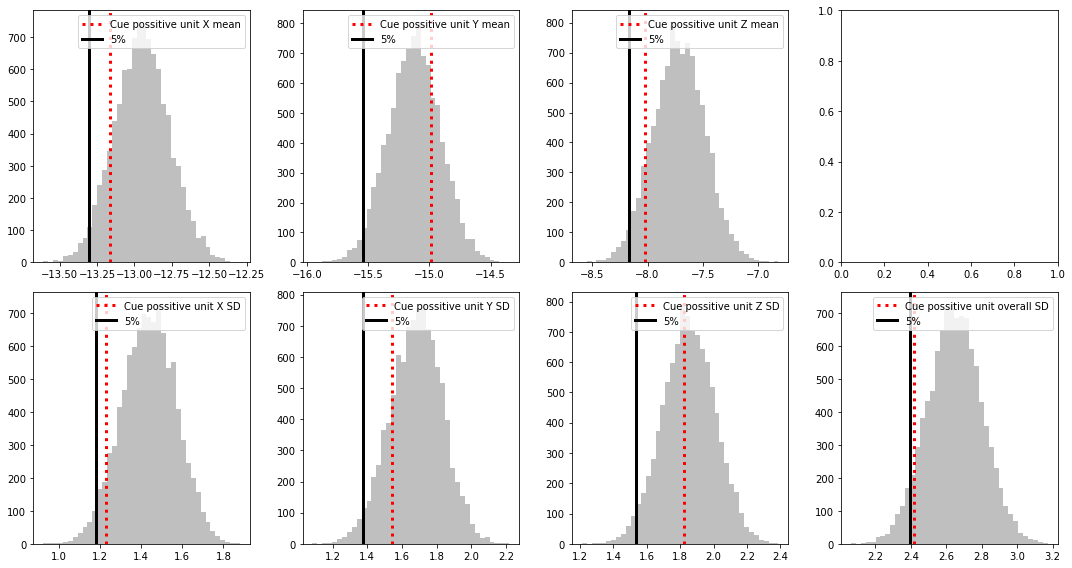

In [67]:
fig, axs = plt.subplots(2, 4, figsize=(15, 8), tight_layout=1)
axs = axs.flatten()

axs[0].hist(rand_x_mean, color='grey', alpha=0.5, bins=40)
axs[0].axvline(mer_loc_cue['MNI_X'].mean(), color='r', linewidth=3, label='Cue possitive unit X mean', linestyle='dotted')
axs[0].axvline(np.sort(rand_x_mean)[int(rand_x_mean.shape[0]*0.025)], color='k', linewidth=3, label='5%')
axs[0].legend()

axs[1].hist(rand_y_mean, color='grey', alpha=0.5, bins=40)
axs[1].axvline(mer_loc_cue['MNI_Y'].mean(), color='r', linewidth=3, label='Cue possitive unit Y mean', linestyle='dotted')
axs[1].axvline(np.sort(rand_y_mean)[int(rand_y_mean.shape[0]*0.025)], color='k', linewidth=3, label='5%')
axs[1].legend()

axs[2].hist(rand_z_mean, color='grey', alpha=0.5, bins=40)
axs[2].axvline(mer_loc_cue['MNI_Z'].mean(), color='r', linewidth=3, label='Cue possitive unit Z mean', linestyle='dotted')
axs[2].axvline(np.sort(rand_z_mean)[int(rand_z_mean.shape[0]*0.025)], color='k', linewidth=3, label='5%')
axs[2].legend()

axs[4].hist(rand_x_sd, color='grey', alpha=0.5, bins=40)
axs[4].axvline(mer_loc_cue['MNI_X'].std(), color='r', linewidth=3, label='Cue possitive unit X SD', linestyle='dotted')
axs[4].axvline(np.sort(rand_x_sd)[int(rand_x_sd.shape[0]*0.025)], color='k', linewidth=3, label='5%')
axs[4].legend()

axs[5].hist(rand_y_sd, color='grey', alpha=0.5, bins=40)
axs[5].axvline(mer_loc_cue['MNI_Y'].std(), color='r', linewidth=3, label='Cue possitive unit Y SD', linestyle='dotted')
axs[5].axvline(np.sort(rand_y_sd)[int(rand_y_sd.shape[0]*0.025)], color='k', linewidth=3, label='5%')
axs[5].legend()

axs[6].hist(rand_z_sd, color='grey', alpha=0.5, bins=40)
axs[6].axvline(mer_loc_cue['MNI_Z'].std(), color='r', linewidth=3, label='Cue possitive unit Z SD', linestyle='dotted')
axs[6].axvline(np.sort(rand_z_sd)[int(rand_z_sd.shape[0]*0.025)], color='k', linewidth=3, label='5%')
axs[6].legend()

axs[7].hist(rand_all_sd, color='grey', alpha=0.5, bins=40)
axs[7].axvline(sd_trial_cue, color='r', linewidth=3, label='Cue possitive unit overall SD', linestyle='dotted')
axs[7].axvline(np.sort(rand_all_sd)[int(rand_all_sd.shape[0]*0.05)], color='k', linewidth=3, label='5%')
axs[7].legend()

plt.show();

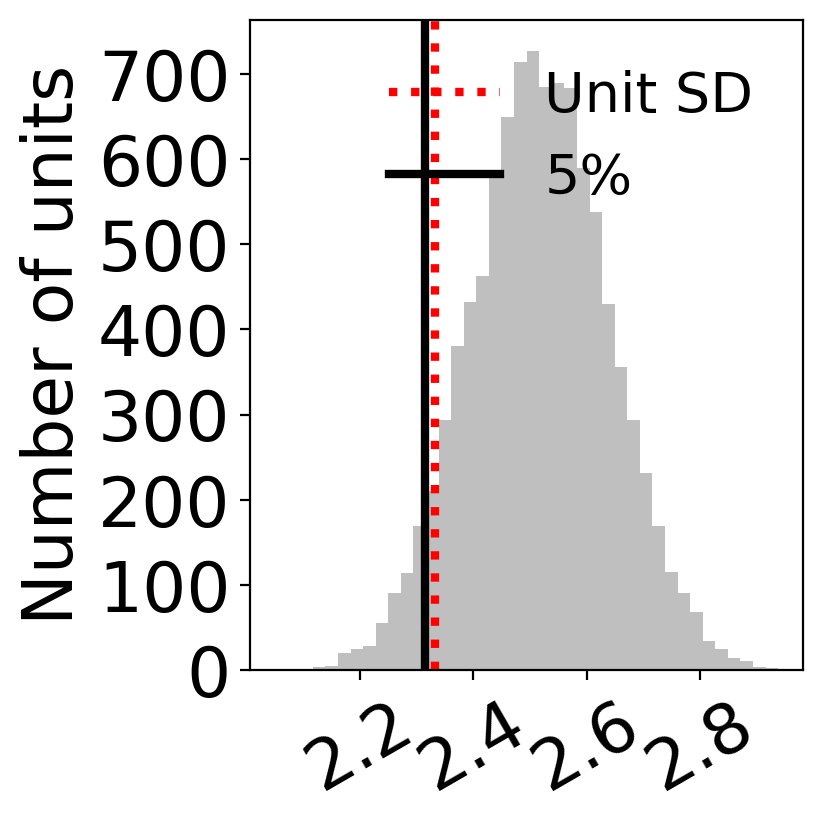

In [151]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4), dpi=200, constrained_layout=1)
axs.patch.set_alpha(0)

axs.hist(rand_all_sd, color='grey', alpha=0.5, bins=40)
axs.axvline(sd_trial_cue, color='r', linewidth=3, label='Unit SD', linestyle='dotted')
axs.axvline(np.sort(rand_all_sd)[int(rand_all_sd.shape[0]*0.05)], color='k', linewidth=3, label='5%')
axs.legend(frameon=0, fontsize=20, loc=1)
axs.set_xticklabels(axs.get_xticks(), fontsize=25, rotation=30)
axs.set_yticklabels(axs.get_yticks().astype(int), fontsize=25)
axs.set_ylabel('Number of units', fontsize=25)

plt.show();


In [94]:
unit_cue_pos.head()

SubjectID  session electrode  unit_id  unit RecType grade  Native_X  \
24   DBS3003        1   micro_m        3     1      SU     A -7.986556   
28   DBS3003        2   micro_p        8     1      MU     C -9.395644   
29   DBS3003        2   micro_p        9     2      MU     B -9.395644   
31   DBS3003        2   micro_m       11     2      MU     C -7.468372   
34   DBS3003        3   micro_c       14     2      MU     F -8.614023   

     Native_Y  Native_Z      MNI_X      MNI_Y      MNI_Z position  Depth  Side  
24 -16.630193  6.363670 -13.245183 -13.666481  -6.942032        m  1.889  left  
28 -18.818952  4.411061 -14.531058 -16.556697  -7.833296        p  0.280  left  
29 -18.818952  4.411061 -14.531058 -16.556697  -7.833296        p  0.280  left  
31 -16.795720  4.849415 -12.730574 -14.414626  -8.574100        m  0.280  left  
34 -17.068632  2.020980 -13.841925 -15.947372 -11.345539        c -2.041  left

In [107]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [124]:
unit_cue_pos_label = np.repeat('pos', len(unit_cue_pos))
unit_cue_neg_label = np.repeat('neg', len(unit_cue_neg))
pos_neg_label_model_y = np.concatenate((unit_cue_pos_label, unit_cue_neg_label))

unit_cue_pos_model_x = unit_cue_pos.iloc[:, 10:13]
unit_cue_neg_model_x = unit_cue_neg.iloc[:, 10:13]
pos_neg_model_x = pd.concat([unit_cue_pos_model_x, unit_cue_neg_model_x])

In [130]:
clf = SVC()
X_train, X_test, y_train, y_test = train_test_split(pos_neg_model_x, pos_neg_label_model_y)
clf.set_params(kernel='linear').fit(X_train, y_train)
pos_neg_score = clf.score(X_test, y_test)
pos_neg_score

SVC(kernel='linear')

0.36363636363636365

In [121]:
shuffle_score = []
for i in range(100):
    random.shuffle(pos_neg_label_model_y)
    X_train, X_test, y_train, y_test = train_test_split(pos_neg_model_x, pos_neg_label_model_y)
    clf.set_params(kernel='linear').fit(X_train, y_train)
    shuffle_score.append(clf.score(X_test, y_test))

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

SVC(kernel='linear')

(array([ 3.,  4., 13., 22., 17., 17.,  8., 10.,  4.,  2.]),
 array([0.27272727, 0.31818182, 0.36363636, 0.40909091, 0.45454545,
        0.5       , 0.54545455, 0.59090909, 0.63636364, 0.68181818,
        0.72727273]),
 <BarContainer object of 10 artists>)

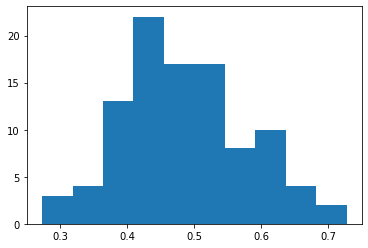

In [123]:
plt.hist(shuffle_score)

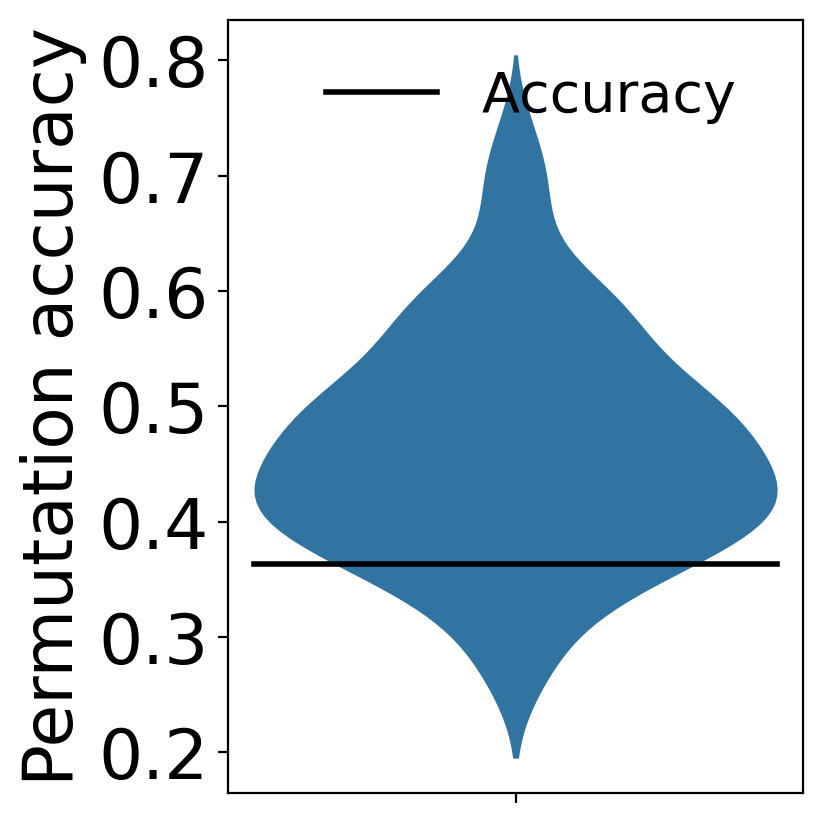

In [155]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(4, 4), dpi=200)
axs.patch.set_alpha(0)

sns.violinplot(np.repeat(0, len(shuffle_score)), shuffle_score, ax=axs, linewidth=0)
axs.plot([-0.4, 0.4], [pos_neg_score, pos_neg_score], 'k-', lw=2, label='Accuracy ')
axs.set_yticklabels([round(item, 2) for item in axs.get_yticks()], fontsize=25)
axs.set_xticklabels([])
axs.legend(fontsize=20, frameon=0)
axs.set_ylabel('Permutation accuracy', fontsize=25)
plt.plot();

In [ ]:
# PC1-PC2
fig, axs = plt.subplots(1, 1, figsize=(8, 5), dpi=200, constrained_layout=1)
axs.patch.set_alpha(0)

sns.scatterplot(stn_pca_xyz[:, 0], stn_pca_xyz[:, 1], 
                ax=axs, hue=stn_pca_xyz[:, 2], legend=0, palette='light:b', linewidth=0, alpha=0.2)
sns.scatterplot(cue_unit_c_pca[:, 0], cue_unit_c_pca[:, 1], 
                hue=cue_unit_c_pca[:, 2], palette='flare', legend='brief', ax=axs, 
                label='Consonant', linewidth=0)
sns.scatterplot(cue_unit_v_pca[:, 0], cue_unit_v_pca[:, 1], 
                hue=cue_unit_v_pca[:, 2], palette='crest', legend='brief', ax=axs, 
                label='Vowel', markers='square', linewidth=0)
axs.legend(title='PC3', fontsize=15, title_fontsize=15, ncol=2)
axs.set_xlabel('PC1', fontsize=25)
axs.set_ylabel('PC2', fontsize=25)
axs.set_title('Syllable encoding location (PCA)', fontsize=30)
axs.set_xticklabels(axs.get_xticks().astype(int), fontsize=25)
axs.set_yticklabels(axs.get_yticks().astype(int), fontsize=25)
plt.show();

In [144]:

deff_x_cue_c = (cue_unit_c['MNI_X'] - cue_unit_c['MNI_X'].mean()) ** 2
deff_y_cue_c = (cue_unit_c['MNI_Y'] - cue_unit_c['MNI_Y'].mean()) ** 2
deff_z_cue_c = (cue_unit_c['MNI_Z'] - cue_unit_c['MNI_Z'].mean()) ** 2

sd_trial_cue_c = 0
for item in range(len(deff_x_cue_c)):
    sd_trial_cue_c += np.sqrt(deff_x_cue_c.iloc[item] + deff_y_cue_c.iloc[item] + deff_z_cue_c.iloc[item])
sd_trial_cue_c = sd_trial_cue_c / len(deff_x_cue_c)

deff_x_cue_v = (cue_unit_v['MNI_X'] - cue_unit_v['MNI_X'].mean()) ** 2
deff_y_cue_v = (cue_unit_v['MNI_Y'] - cue_unit_v['MNI_Y'].mean()) ** 2
deff_z_cue_v = (cue_unit_v['MNI_Z'] - cue_unit_v['MNI_Z'].mean()) ** 2

sd_trial_cue_v = 0
for item in range(len(deff_x_cue_v)):
    sd_trial_cue_v += np.sqrt(deff_x_cue_v.iloc[item] + deff_y_cue_v.iloc[item] + deff_z_cue_v.iloc[item])
sd_trial_cue_v = sd_trial_cue_v / len(deff_x_cue_v)


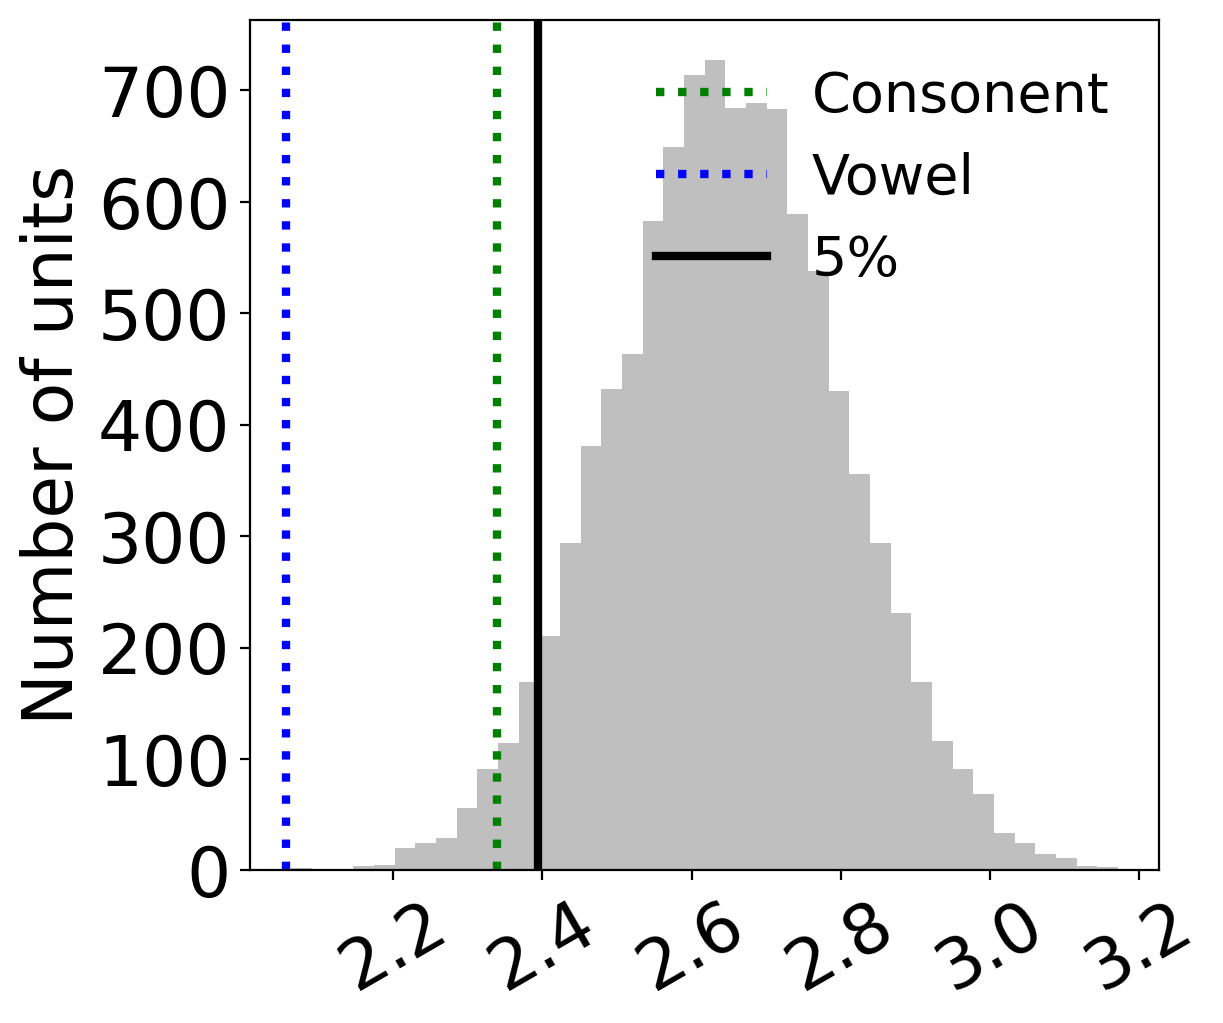

In [156]:
fig, axs = plt.subplots(1, 1, figsize=(6, 5), dpi=200, constrained_layout=1)
axs.patch.set_alpha(0)

axs.hist(rand_all_sd, color='grey', alpha=0.5, bins=40)
axs.axvline(sd_trial_cue_c, color='g', linewidth=3, label='Consonent', linestyle='dotted')
axs.axvline(sd_trial_cue_v, color='b', linewidth=3, label='Vowel', linestyle='dotted')
axs.axvline(np.sort(rand_all_sd)[int(rand_all_sd.shape[0]*0.05)], color='k', linewidth=3, label='5%')
axs.legend(frameon=0, fontsize=20, loc=1)
axs.set_xticklabels(axs.get_xticks(), fontsize=25, rotation=30)
axs.set_yticklabels(axs.get_yticks().astype(int), fontsize=25)
axs.set_ylabel('Number of units', fontsize=25)
plt.show();
